# Large Scale Fast Image Processing on an Ordinary Computer

This notebook shows how to process a lot of GB's extremely fast in a simple manner. We will generate a couple of GB's of images, and process them in a couple of minutes on a Google Colab with 2 vCPUs and 13GB of RAM.

__Why Huggingface datasets?__</br>
PIL images are first class citizens, you do not need to (de)serialize the images when reading/storing them into a huggingface dataset.

__Why Arrow?__</br>
The Arrow data format allows for 0 overhead when reading the data from your hard drive, you could say that you can extend the computer's RAM memory to your hard drive. Imagine you have 50 GB's of images ready in RAM memory and process them, wouldn't take more than a couple of minutes right? Right!

More info:
- https://huggingface.co/docs/datasets/about_arrow
- https://huggingface.co/docs/datasets/loading#python-generator

In [2]:
!pip install datasets numpy pillow ipython-autotime --quiet
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.6 MB/s eta 0:00:00
time: 387 µs (started: 2024-04-22 08:24:10 +00:00)


## 1. Generating a Bunch of Random Images

The from_generator allows to stream your images to disk, like this you can read (or generate) larger than RAM memory image datasets and write them to disk. This process can take around 30 minutes!

In [4]:
import io
import numpy as np
from PIL import Image
from datasets import Dataset

def image_generator(num_images):
  """512*512 pixel picture with random colors."""
  for _ in range(num_images):
    random_data = np.random.randint(0, 256, (512, 512, 3), dtype=np.uint8)
    yield {'image': Image.fromarray(random_data, 'RGB')}


NUM_IMAGES = 10_000
ds = Dataset.from_generator(
      generator=image_generator,
      # datasets will cache the dataset we get via the generator in chunks.
      cache_dir="~/.cache/huggingface/datasets/large-scale-fast-image-processing",
      gen_kwargs={"num_images":NUM_IMAGES}
    )



Generating train split: 0 examples [00:00, ? examples/s]

time: 22min 59s (started: 2024-04-22 08:24:49 +00:00)


Unfortunately we cannot load the dataset from the cache at a later point, you _have to_ save the dataset using "save_to_disk".

In [5]:
!mkdir -p "./image-dataset"
ds.save_to_disk("./image-dataset")

Saving the dataset (0/16 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

time: 1min 47s (started: 2024-04-22 08:50:25 +00:00)


In [6]:
# print the size of the dataset
!du -h ./image-dataset

7.4G	./image-dataset
time: 107 ms (started: 2024-04-22 08:52:12 +00:00)


## 2. Processing a Bunch of Images

We process all the images in the huggingface datasets and resize them to 30*30 pixel thumbnails.

In [ ]:
import datasets

ds = datasets.load_from_disk("./image-dataset")

# we need to convert the Dataset to an IterableDataset (more info below)
ds = ds.to_iterable_dataset()

# we use the huggingface datasets map function to iterate over all rows.
def resize_image(row):
    row['image_resized'] = row['image'].resize((30, 30))
    return row
ds_resized = ds.map(resize_image)

# We trigger the lazy execution by printing the progress. (more info below)
for i,row in enumerate(ds_resized):
    print(f"\rResizing image {i+1}/{NUM_IMAGES}", end='')


Resizing image 10000/10000time: 2min 22s (started: 2024-04-22 08:52:40 +00:00)


# image of 30*30


# image of 512*512


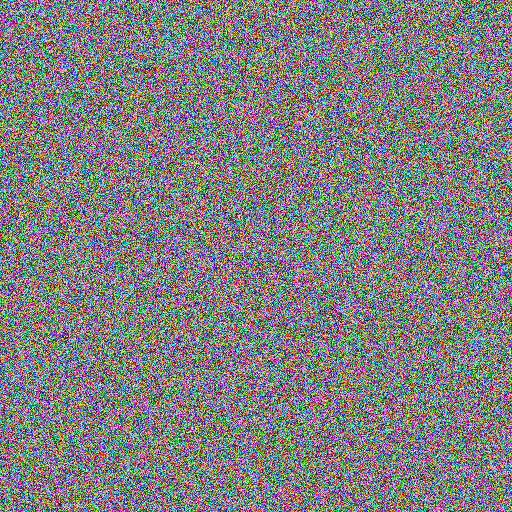

time: 307 ms (started: 2024-04-22 08:58:43 +00:00)


In [16]:
from IPython.display import display

print("# image of 30*30")
display(row["image_resized"])

print("# image of 512*512")
display(row["image"])


## Gotcha's

- __Dataset vs IterableDataset__: HuggingFace's `Dataset` fully loads into memory like a pandas dataframe, where `IterableDataset` is optimal for streaming large datasets sequentially, applying transformations on-the-fly during iteration.

- __Fast Read and Process, slow Write__: An `IterableDataset` written in the arrow format allows you to read and process data fast but writing data is slow. So when the output is relative small compared to the input, for example you train a model or you need some aggregations, you're good.

- __Lazy Data Processing__: `IterableDataset` exectues code lazy. Transformations applied to datasets are not executed until the data is actually accessed. The advantage is that the sequence of processing steps can be optimized. The downside is that you delay error detection and complicate debugging processes.